## Sign language translation
#### ANN Network
#### Author : Gyan Krishna

In [19]:
from keras.layers import Dense, Flatten, Dropout, Activation, Reshape
from keras.models import Sequential
from keras.utils import np_utils, plot_model, to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from numpy import argmax
import pydot
import os

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

#tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1
Default GPU Device: /device:GPU:0


## Loading the data set

In [3]:
model_images_path = os.path.join(os.getcwd(),r'model_images')
accuracy_plots_path =os.path.join(os.getcwd(), r'accuracy_plots')

npx_path = os.path.join(os.getcwd(), r"npx_dataset")
x_data = np.load(os.path.join(npx_path, "x_data.npy"))
y_data = np.load(os.path.join(npx_path, "y_data.npy"))

print(x_data.shape)
print(y_data.shape)

(87000, 100, 100)
(87000,)


## Splitting the data set 

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.15)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.15)


print("x train shape      : ", x_train.shape)
print("y train shape      : ", y_train.shape)
print("\nx validation shape : ", x_valid.shape)
print("y validation shape : ", y_valid.shape)
print("\nx test shape       : ", x_test.shape)
print("y test shape       : ", y_test.shape)

x train shape      :  (62857, 100, 100)
y train shape      :  (62857,)

x validation shape :  (11093, 100, 100)
y validation shape :  (11093,)

x test shape       :  (13050, 100, 100)
y test shape       :  (13050,)


## Normalizing the data set


In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_valid = x_valid.astype('float32')

x_train /= 255
x_test /= 255
x_valid /= 255

## Converting y_test and y_train to categorical data

In [6]:
n_category = 29
y_train = np_utils.to_categorical(y_train, n_category)
y_test  = np_utils.to_categorical(y_test,  n_category)
y_valid = np_utils.to_categorical(y_valid,  n_category)

## Creating the base line model

In [7]:
def baseline_model():
    model = Sequential()
    model.add(Flatten(input_shape = (100, 100)))
    model.add(Dense(650, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(350, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(29))
    model.add(Activation('softmax'))

    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 650)               6500650   
_________________________________________________________________
dropout (Dropout)            (None, 650)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               227850    
_________________________________________________________________
dropout_1 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 29)                10179     
_________________________________________________________________
activation (Activation)      (None, 29)                0

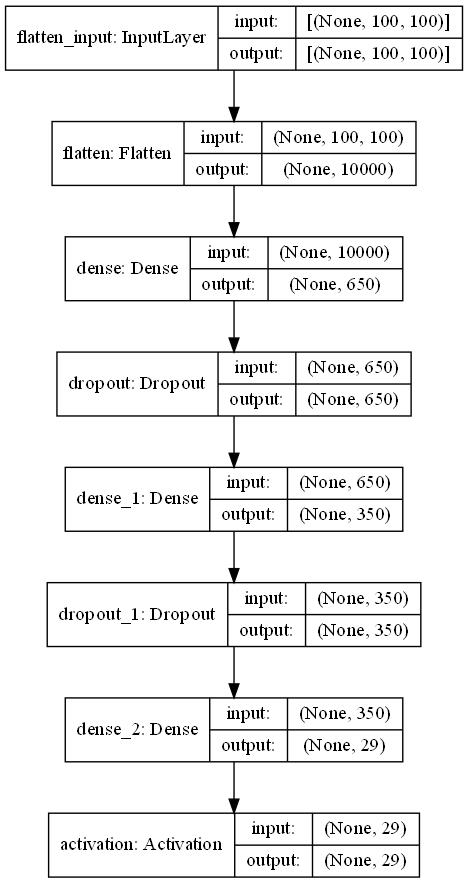

In [8]:
model = baseline_model()
plot_model(model,
          to_file = os.path.join(accuracy_plots_path, "ann_baseline.jpg"),
          show_shapes = True,
          show_layer_names = True,
          rankdir = "TB",
          expand_nested = False,
          dpi = 100)

In [9]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['categorical_accuracy'])

In [10]:
epochs = 100
model_log = model.fit(x_train, y_train, 
                      batch_size = 256, 
                      epochs = 100, 
                      verbose = 1,
                      validation_data = (x_valid, y_valid))

Epoch 1/100
246/246 [==============================] - 6s 21ms/step - loss: 3.6712 - categorical_accuracy: 0.0811 - val_loss: 2.4603 - val_categorical_accuracy: 0.2478
Epoch 2/100
246/246 [==============================] - 4s 15ms/step - loss: 2.5482 - categorical_accuracy: 0.2085 - val_loss: 2.1397 - val_categorical_accuracy: 0.3093
Epoch 3/100
246/246 [==============================] - 4s 15ms/step - loss: 2.2638 - categorical_accuracy: 0.2735 - val_loss: 1.7976 - val_categorical_accuracy: 0.4403
Epoch 4/100
246/246 [==============================] - 4s 15ms/step - loss: 2.0173 - categorical_accuracy: 0.3380 - val_loss: 1.5942 - val_categorical_accuracy: 0.4936
Epoch 5/100
246/246 [==============================] - 4s 15ms/step - loss: 1.9036 - categorical_accuracy: 0.3644 - val_loss: 1.5381 - val_categorical_accuracy: 0.4896
Epoch 6/100
246/246 [==============================] - 4s 15ms/step - loss: 1.7863 - categorical_accuracy: 0.3988 - val_loss: 1.3889 - val_categorical_accuracy:

In [11]:
def evaluate_model(model, model_log, model_name):
    #print(model_log.history['loss'])
    print("train loss = ", model_log.history['loss'][-1])
    print("train accuracy = ", model_log.history['categorical_accuracy'][-1])
          
    print("test loss = ", model_log.history['val_loss'][-1])
    print("test accuracy = ", model_log.history['val_categorical_accuracy'][-1])

    plt.subplot(2,1,1)
    plt.title(model_name+' accuracy')
    plt.plot(range(1, epochs+1), model_log.history['categorical_accuracy'])
    plt.plot(range(1,  epochs+1), model_log.history['val_categorical_accuracy'])
    
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    
    plt.subplot(2,1,2)
    plt.title(model_name+' loss')
    plt.plot(model_log.history['loss'])
    plt.plot(model_log.history['val_loss'])
    
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'test'], loc='lower right')
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(model_images_path, model_name+"model.jpg"))
    return

train loss =  0.9583377242088318
train accuracy =  0.6705219745635986
test loss =  0.7142041325569153
test accuracy =  0.7530875205993652


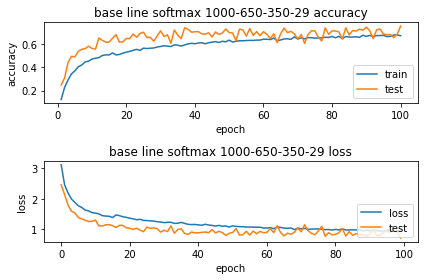

In [16]:
evaluate_model(model, model_log, "base line softmax 1000-650-350-29")

# Evaluating testing data

In [13]:
results = model.evaluate(x_test, y_test, batch_size = 256)
print("\n\n test loss, test accuracy = ",results)

51/51 [==============================] - 0s 9ms/step - loss: 0.7054 - categorical_accuracy: 0.7605


 test loss, test accuracy =  [0.7053684592247009, 0.7605363726615906]


## Generating y prediction on the test dataset

In [119]:
y_pred = []
labels = ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
for i in range(len(x_test)):
    test = np.expand_dims(x_test[i], 0)
    pred = model.predict_classes(test)[0]
    y_pred.append(pred)
print("done!")

done!


# similar symbols:
1. A, E, M, N, S, T
2. W,F
3. G, H